# Computer Vision by PyTorch from Scratch

PyTorch is a powerful tool to prototype Neural Network which is a widely-spread deep learning algorithm applied in many pratical fields. In this tutorial, we are going to talk about some basis of this framework and use PyTorch to build a small Neural Network to solve an interesing Computer Vision classification problem.

In [1]:
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen

Before we talk about PyTorch, let's first talk about numpy. In pratical data sciences today, most of the Machine Learning algorithms are implememnted through matrices. Numpy is also known as a famous library which deals with matrices. So, let's see some connection and comparison between two libraries.

In [2]:
# The n-dimension array in PyTorch is called Tensor
import torch
import numpy as np
from pprint import pprint

# Torch tensor can easily be translated to numpy array.
x = torch.rand(5, 3)
pprint(x.numpy())

# Also tensor can be easily initiated through numpy array.
y = torch.from_numpy(np.random.rand(5, 3))
pprint(y)

array([[ 0.04943347,  0.63093764,  0.62319583],
       [ 0.8915984 ,  0.5279544 ,  0.60156339],
       [ 0.03036225,  0.84217393,  0.88641548],
       [ 0.04505414,  0.13173079,  0.63485622],
       [ 0.83734661,  0.44466114,  0.37308985]], dtype=float32)

 0.7196  0.6654  0.1477
 0.2570  0.7907  0.8597
 0.4610  0.4650  0.4002
 0.1285  0.9168  0.7316
 0.5982  0.3678  0.3192
[torch.DoubleTensor of size 5x3]



For batch data processing in GPU is much faster than in single thread CPU, so nowadays, people are more and more willing to make their Machine Learning algorithms 'born with' parallelism. Because of this, researchers and engineers tend to use PyTorch to prototype instead of numpy for the latter is short of GPU support. Now let's dive a little deep to see what else PyTorch can do with its well-known power over building a Neural Network.

`autograd` is a module in PyTorch to calculate the gradient automatically once you define the layer(forward feed in Neural Network). Let's try doing an easy gradient calculation using PyTorch.

In [3]:
from torch.autograd import Variable

# If we try to calculate the derivative of x due to y(dy/dx)
# Derivative is a special case of gradient, as it has only a single dimension.
x = Variable(torch.ones(1), requires_grad=True)
y = x * x + 2 * x + 1

# We need to pass the structure of x.
y.backward(x)
pprint(x.grad)

Variable containing:
 4
[torch.FloatTensor of size 1]



As we can see the result is $4$. Basically, we can see the derivative of the function is $2 \times x + 2$, and we apply $x = 1$ to the derivative, we get $\frac{dy}{dx} = 4$. This answer is the same as the `autograd` module gives us. For this is just a very basic function in calculating gradient, we can compute the derivative by ourselves, but when we have a much complicated one, which is a common case in multi-layer Neural Network, `autograd` can be our life-saver. Another important thing is you will never worry about the correctness of `autograd`, which makes our lives much easier. Let's see a real Neural Network example to feel the convenience that `autograd` brings to us.

We are about to build a fully connected Neural Network with only one-hidden layer. The post-activition function of that hidden layer is **sigmoid**. As you may have no idea is the derivative of sigmoid is, or you may even don't know what sigmoid is, while you may heard sigmoid is a good candidate post-activition function for Neural Network. In PyTorch, you can just directly use it without worrying all the above.

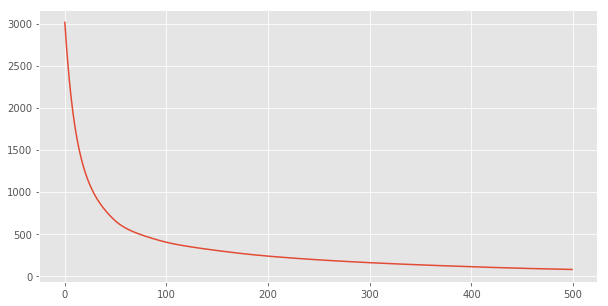

In [4]:
# N is the number of the label data, M is the feature size.
# H is the hidden layer size, D is the output size.
N, M, H, O = 16, 200, 40, 8

# Specify the data type for the Tensor in PyTorch.
dtype = torch.FloatTensor

# The input labeled examples, as we don't need to compute the gradients for them,
# we specify it at initialization, which prevents extra computation in backward.
x = Variable(torch.randn(N, M).type(dtype), requires_grad=False)
y = Variable(torch.randn(N, O).type(dtype), requires_grad=False)

# The weights for each layer, these are the actual parameters we are going to optimize.
# w1 is the weights for the hidden layer, w2 is for the output layer.
w1 = Variable(torch.randn(M, H).type(dtype), requires_grad=True)
w2 = Variable(torch.randn(H, O).type(dtype), requires_grad=True)

# Let's begin our computation!
learning_rate = 1e-4
losses = []
for i in range(500):
    y_pred = x.mm(w1).sigmoid().mm(w2)
    
    # The square loss function.
    loss = (y - y_pred).pow(2).sum()
    losses.append(loss.data[0])
        
    loss.backward()
    
    # Update the weight with gradients
    w1.data -= learning_rate * w1.grad.data
    w2.data -= learning_rate * w2.grad.data
    
    # Make the temporary gradient calculation zero.
    w1.grad.data.zero_()
    w2.grad.data.zero_()

plt.plot(losses)
plt.show()

We can observe that our Network converges. In the code above, we never explicit call or define how the back propagation should goes on, because the autograd module just help us compute those once we define the behavior of the feed-forward in Neural Network. You may have question about how this Neural Network utilize the power of GPU? It is very simple. Just define the data type as `torch.cuda.FloatTensor` if your PyTorch supports cuda.

Let's move foward to `nn` package which a higher level abstraction of building Neural Networks. Actually, when we define Neural Network, we don't need to dive deep into each operation in the function. What we usually see in the paper are what they have done in each **layer** or how they combine different existing **layers**. What I am saying is in most of the time, we just need to define the attibute of the layers, not actually creating new fancy operations. Let's take a brief look on how to use `nn` package to define a Neural Network. To be honest, it is relatively similar as using `autgrad` for `nn` depends a lot on `autograd`.

We are going to build the above Neural Network above with the `nn` package.

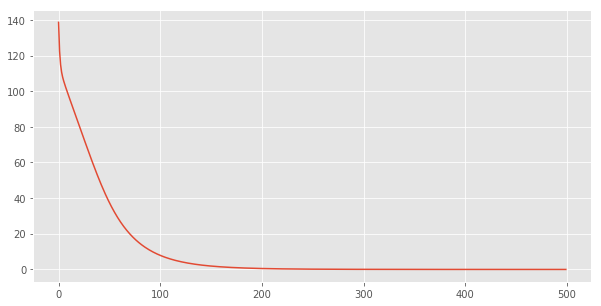

In [5]:
import torch.nn as nn

from collections import OrderedDict

# Same setting here.
N, M, H, O = 16, 200, 40, 8

dtype = torch.FloatTensor

x = Variable(torch.randn(N, M).type(dtype))
y = Variable(torch.randn(N, O).type(dtype), requires_grad=False)

model = nn.Sequential(
    OrderedDict([
        # hidden layer 1
        ('linear1', nn.Linear(M, H)),
        ('sigmoid1', nn.Sigmoid()),

        # output layer
        ('output', nn.Linear(H, O)),
    ])
)

loss_fn = nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

losses = []
for i in range(500):
    loss = loss_fn(model(x), y)
    losses.append(loss.data[0])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(losses)
plt.show()

As you see, two weights $w1$ and $w2$ which is used to be updated by ourselves is now managed by the `nn` package. We can define multiple complicated layers in the `nn.Sequential` module and label them with some intuitive names. The clear declaration way of buiding Neural Network strongly improve the maintainence of the code. Also in this version, the loss function and the update function are also two parameterizable module.

Okay, it's time to step forward to make our hands dirty and do some real work. Neural Network is very powerful in Computer Vision. The reason behind this is that the kernel(or the feature extracter) which is used to be pre-defined in Computer Vision, can actually be trained through Neural Network! Let's first see an simple example Neural Network with Convolutional Layer.

In [6]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.feature_model = nn.Sequential(
            OrderedDict([
                # 1
                ('conv1', nn.Conv2d(1, 2, 5)),
                ('relu1', nn.ReLU()),
                ('pool1', nn.MaxPool2d(2)),
                
                # 2
                ('conv2', nn.Conv2d(2, 8, 5)),
                ('relu2', nn.ReLU()),
                ('pool2', nn.MaxPool2d(2)),
            ])
        )

        self.classifier = nn.Sequential(
            OrderedDict([
                # 3
                ('line3', nn.Linear(8 * 5 * 5, 80)),
                ('relu3', nn.ReLU()),
                
                # 4
                ('line4', nn.Linear(80, 5)),
            ])
        )

    def forward(self, x):
        x = self.feature_model(x)
        x = x.view(-1, 8 * 5 * 5)
        x = self.classifier(x)
        return x


net = MyNeuralNetwork()
pprint(net)

out = net(Variable(torch.randn(1, 1, 32, 32)))
pprint(out)
net.zero_grad()
out.backward(torch.ones(1, 5))

MyNeuralNetwork(
  (feature_model): Sequential(
    (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (conv2): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (line3): Linear(in_features=200, out_features=80, bias=True)
    (relu3): ReLU()
    (line4): Linear(in_features=80, out_features=5, bias=True)
  )
)
Variable containing:
 0.0847  0.0606 -0.0399 -0.1014 -0.0178
[torch.FloatTensor of size 1x5]



The Neural Network above is a very simple Convolutional Neural Network. It has two convolutional layers, which both uses a $5 \times 5$ kernel. The first layer uses a single $32 \times 32$ matrix as input and outputs 6 $28 \times 28$ matrices. This is because after applying convolution operation, the matrix itself would get smaller. The shrink size is the size of the kernel - 1, therefore we can get $32 - 5 + 1 = 28$. What worth mention here is the reason we try to use convolutional layer instead of traditional fully-connected Neural Network. Besides the reason we state above, its relationship to the 'feature extractor' by analogy, another important reason is the performance concern. Convolutional layer have more parallelism in computation and less data to compute.

After that, we also apply the same two additional operation in two layer, `ReLU` as an usual post-activition layer and a `MaxPool` layer as a subsample pooling layer. `ReLU` is a popular function that researchers discover that it performs better in Computer Vision problem than `sigmoid` as a usual post-activition. `MaxPool` is a pretty good way to 'manually' control the size of the matrix. For convolution operation automatically decrease the size of the matrix, people tend to add padding to recover it and then use Pooling mechanism instead to control the size of the data, which also out-performs in practice. These are both common strategies in Convolutional Neural Network when it is used to solve Computer Vision problem.

One the second convolutional layer, the input size is the output size of the last layer which is $2$ in this net. With output size is $8$, we can conclude the number of the all elements in the output should be $8 \times [(14 - 5 + 1) / 2]^2$.

This time, we have done all the work that traditional Computer Vision algorithm have done, namely **feature extraction**. After that, we can use classification algorithms, like a fully-connected network, to classify the picture or detect the things. So, after the feature extracting, or probabaly feature learning is a better name, we add a single hidden-layer Neural Network to do classification. As this time, we are not treating data as matrix, we just flatten the outputs and handle them as a vector. For we have discussed a lot about fully-connected Neural Network, we just skip talking about this part.

Let's move to make a real example to classify images through buiding a Neural Network by PyTorch. A very basic thing that the Convolutional Neural Network can do is classifying handwriting numbers. For the simplicity of the problem, we can just modify a little based on the above Convolutional Neural Network.

In [7]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.feature_model = nn.Sequential(
            OrderedDict([
                # 1
                ('conv1', nn.Conv2d(1, 10, 5)),
                ('relu1', nn.ReLU()),
                ('pool1', nn.MaxPool2d(2)),
                
                # 2
                ('conv2', nn.Conv2d(10, 20, 5)),
                ('relu2', nn.ReLU()),
                ('pool2', nn.MaxPool2d(2)),

            ])
        )
        
        self.classifier = nn.Sequential(
            OrderedDict([
                # 3
                ('line3', nn.Linear(320, 50)),
                ('relu3', nn.ReLU()),

                # 4
                ('line4', nn.Linear(50, 10)),
                ('soft4', nn.LogSoftmax(dim=1))
            ])
        )

    def forward(self, x):
        x = self.feature_model(x)
        x = x.view(-1, 320)
        x = self.classifier(x)
        return x

As you see above we just update the parameters of some functions. The input image size of this network is $28 \times 28$. The final output layer we use the `LogSoftmax` function which is also known as a good classification function. Let's load some data and train it.

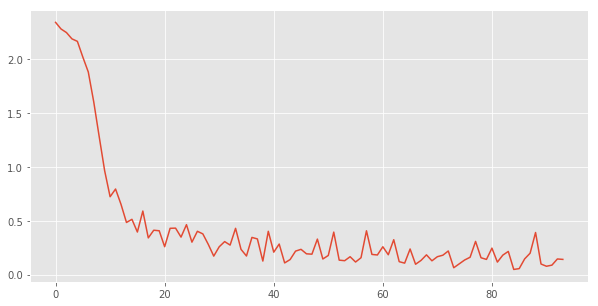

In [8]:
import torch.utils.data as torch_data
from torchvision import datasets, transforms

# This loader is cited from https://github.com/pytorch/examples/blob/master/mnist/main.py
train_loader = torch_data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True)

model = MyNeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)

model.train()
losses = []
for i, (x, y) in enumerate(train_loader):
    x, y = Variable(x), Variable(y)
    optimizer.zero_grad()
    y_pred = model(x)
    loss = torch.nn.functional.nll_loss(y_pred, y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        losses.append(loss.data[0])

plt.plot(losses)
plt.show()

We can also load the test data to see the performance of our trained network.

In [9]:
# This loader is cited from https://github.com/pytorch/examples/blob/master/mnist/main.py
test_loader = torch_data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=1000, shuffle=True)

model.eval()
correct = 0
for x, y in test_loader:
    x, y = Variable(x, volatile=True), Variable(y)
    y_pred = model(x)
    pred = y_pred.data.max(1, keepdim=True)[1] # Get the idex of the max log-probability
    correct += pred.eq(y.data.view_as(pred)).long().cpu().sum() # Get number of the correctness

print('Test ser accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

NameError: name 'test_loss' is not defined